In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

In [2]:
import autogluon as ag
import mxnet as mx
import mxnet.gluon.nn as nn
import mxnet.ndarray as nd

In [3]:
from bmxnet_examples.binary_models.meliusnet import meliusnet22
from models.meliusnet_enas import meliusnet22_enas

In [4]:
from autogluon.contrib.enas import *
from gluoncv.model_zoo.cifarresnet import CIFARResNetV1, CIFARBasicBlockV1
from bmxnet_examples.binary_models.meliusnet import meliusnet22
from mxboard import *

In [5]:
import json

In [6]:
sw  = SummaryWriter(logdir='../tensorboard_logs')

### Get the enas sequential of meliusnet22

In [7]:
mnet_enas = meliusnet22_enas().enas_sequential

Features in transition 1: 320 -> 160
Features in transition 2: 480 -> 224
Features in transition 3: 480 -> 256


### Init ENASSequential
Throw a sample input into the network in order to initialize the sizes for each layer, otherwise the scheduler can't run this

shape is (?, input layers, input width, input height)

In [8]:
mnet_enas.hybridize()
mnet_enas.initialize()

In [9]:
fake_input = nd.random.uniform(shape=(1, 3, 32, 32))

In [10]:
latency_eval_output = mnet_enas.evaluate_latency(fake_input)

## Create symbolic graph for enas meliusnet

In [11]:
data = mx.sym.Variable('data')

In [12]:
result = mnet_enas(data)

In [13]:
sw.add_graph(result)

successfully opened events file: ../tensorboard_logs/events.out.tfevents.1591886751.Acer-Aspire-E5
wrote 1 event to disk
wrote 1 event to disk


In [14]:
type(result)

mxnet.symbol.symbol.Symbol

In [15]:
from mxboard.summary import _get_nodes_from_symbol
from mxboard.proto.graph_pb2 import GraphDef
from mxboard.proto.versions_pb2 import VersionDef

## Create symbolic graph for Joseph Meliusnet22

In [7]:
from util.arg_parser import get_parser
from image_classification import get_model
import image_classification
import re
import sys

In [8]:
args = '''--data-path \"/path/to/cifar/\"
--augmentation low
--batch-size 128
--clip-threshold 1.3
--dataset cifar100
--epochs 150
--gpus 0
--log-interval 50
--lr 0.02
--lr-mode cosine
--mode hybrid
--model meliusnet22
--optimizer adam
--warmup-epochs 5'''

In [9]:
arg_list = re.split(' |\n',args)

In [10]:
old_args = sys.argv[1:]
sys.argv[1:] = arg_list
parser = get_parser()
opt = parser.parse_args()
sys.argv[1:] = old_args

In [11]:
context = [mx.gpu(int(i)) for i in opt.gpus.split(',')] if opt.gpus.strip() else [mx.cpu()]

In [12]:
image_classification.opt = opt

In [13]:
net, arg_params, aux_params = get_model(opt, context)

Features in transition 1: 320 -> 160
Features in transition 2: 480 -> 224
Features in transition 3: 480 -> 256


In [14]:
net.hybridize()

In [15]:
bogus_input = nd.random.uniform(shape=(1, 3, 32, 32))
bogus_input = bogus_input.copyto(context[0])

In [16]:
_ = net(bogus_input)

In [17]:
sw.add_graph(net)

successfully opened events file: ../tensorboard_logs/events.out.tfevents.1591886929.Acer-Aspire-E5
wrote 1 event to disk
wrote 1 event to disk


### Render the Graph
as this requires graphviz, you need to (in addition to the python package) install it on your system by calling `` sudo apt-get install graphviz``

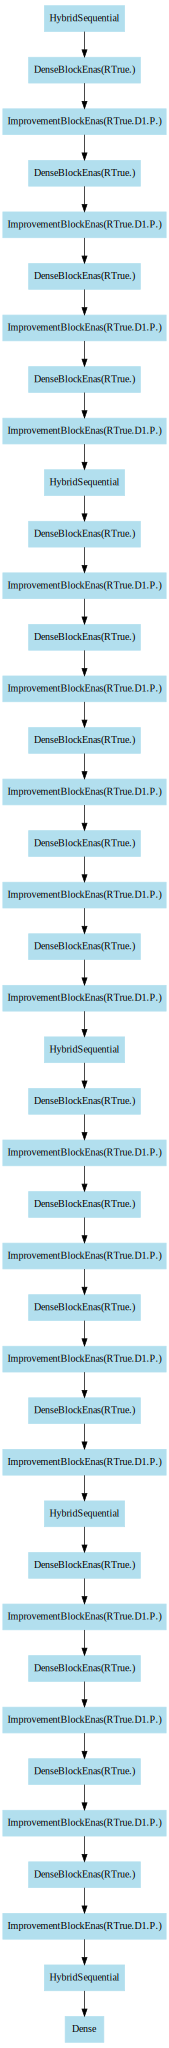

In [44]:
# render in notebook
mnet_enas.graph

In [45]:
# render to PDF
dia = mnet_enas.graph
dia.render()

'Digraph.gv.pdf'

In [12]:
from mxboard.summary import _get_nodes_from_symbol
from mxboard.proto.graph_pb2 import GraphDef
from mxboard.proto.versions_pb2 import VersionDef

In [13]:
def symbolic_supernet_from_enas_sequential(enas_sequential, prefixes={}, counts=[0,0,0]):
    data = mx.sym.Variable('data')
    for module in enas_sequential._modules.values():
        if isinstance(module, ENAS_Sequential):
            symbol, prefixes = symbolic_supernet_from_enas_sequential(module, prefixes, counts)
            counts[0] += 1
            nodes = json.loads(symbol.tojson())['nodes']
            for node in nodes:
                prefixes[node['name']] = 'ENAS_Sequential' + str(counts[0]) + '/' + prefixes[node['name']]
        elif isinstance(module, ENAS_Unit):
            possible_outputs = []
            for block in module.module_list:
                #seq.add(block)
                possible_outputs.append(block(data))
            stacked = mx.symbol.stack(*possible_outputs)
            nodes = json.loads(stacked.tojson())['nodes']
            for node in nodes:
                prefixes[node['name']] = 'ENAS_Unit' + str(counts[1]) + '/'
            controller_output = mx.sym.Variable('controller_output')
            data = mx.symbol.pick(stacked, controller_output, name='ENAS_Unit/pick_alternative')
            counts[1] += 1
        else:
            nodes = json.loads(module._cached_graph[1].tojson())['nodes']
            for node in nodes:
                prefixes[node['name']] = 'Normal_Unit'  + str(counts[2]) + '/'
            data = module(data)
            counts[2] += 1
    
    return module(data), prefixes

In [16]:
mxnet_symbolic, prefixes = symbolic_supernet_from_enas_sequential(mnet_enas)
conf = json.loads(mxnet_symbolic.tojson())
nodes = conf['nodes']
for i, node in enumerate(nodes):
    name = node['name']
    nodes[i]['name'] =  prefixes[name] + name
conf['nodes'] = nodes
node_defs = _get_nodes_from_symbol(mx.symbol.load_json(json.dumps(conf)))
sw._file_writer.add_graph( GraphDef(node=node_defs, versions=VersionDef(producer=100)))

successfully opened events file: ../tensorboard_logs/events.out.tfevents.1590845916.lukas-MS-7C02
wrote 1 event to disk
wrote 1 event to disk


In [48]:
prefixes

{'data': 'Normal_Unit5/',
 'conv0_weight': 'ENAS_Unit33/',
 'conv0_fwd': 'ENAS_Unit33/',
 'batchnorm0_gamma': 'ENAS_Unit33/',
 'batchnorm0_beta': 'ENAS_Unit33/',
 'batchnorm0_running_mean': 'ENAS_Unit33/',
 'batchnorm0_running_var': 'ENAS_Unit33/',
 'batchnorm0_fwd': 'ENAS_Unit33/',
 'relu0_fwd': 'ENAS_Unit33/',
 'pool0_fwd': 'ENAS_Unit33/',
 'stage1_batchnorm0_gamma': 'ENAS_Unit33/',
 'stage1_batchnorm0_beta': 'ENAS_Unit33/',
 'stage1_batchnorm0_running_mean': 'ENAS_Unit33/',
 'stage1_batchnorm0_running_var': 'ENAS_Unit33/',
 'stage1_batchnorm0_fwd': 'ENAS_Unit33/',
 'stage1_qactivation0_gradcancel0': 'ENAS_Unit33/',
 'stage1_qactivation0_det_sign0': 'ENAS_Unit33/',
 'stage1_qconv0_pad0': 'ENAS_Unit33/',
 'stage1_qconv0_weight': 'ENAS_Unit33/',
 'stage1_qconv0_det_sign0': 'ENAS_Unit33/',
 'stage1_qconv0_fwd': 'ENAS_Unit33/',
 'stage1_qconv0__plusscalar0': 'ENAS_Unit33/',
 'stage1_qconv0__divscalar0': 'ENAS_Unit33/',
 'stage1_denseblockenas0_concat0': 'ENAS_Unit33/',
 'stage1_batchnorm

In [46]:
nodes

[{'op': 'null', 'name': 'Normal_Unit5/data', 'inputs': []},
 {'op': 'null',
  'name': 'ENAS_Unit33/conv0_weight',
  'attrs': {'__dtype__': '0',
   '__lr_mult__': '1.0',
   '__shape__': '(64, 0, 7, 7)',
   '__storage_type__': '0',
   '__wd_mult__': '1.0'},
  'inputs': []},
 {'op': 'Convolution',
  'name': 'ENAS_Unit33/conv0_fwd',
  'attrs': {'dilate': '(1, 1)',
   'kernel': '(7, 7)',
   'layout': 'NCHW',
   'no_bias': 'True',
   'num_filter': '64',
   'num_group': '1',
   'pad': '(3, 3)',
   'stride': '(2, 2)'},
  'inputs': [[0, 0, 0], [1, 0, 0]]},
 {'op': 'null',
  'name': 'ENAS_Unit33/batchnorm0_gamma',
  'attrs': {'__dtype__': '0',
   '__init__': 'ones',
   '__lr_mult__': '1.0',
   '__shape__': '(0,)',
   '__storage_type__': '0',
   '__wd_mult__': '1.0'},
  'inputs': []},
 {'op': 'null',
  'name': 'ENAS_Unit33/batchnorm0_beta',
  'attrs': {'__dtype__': '0',
   '__init__': 'zeros',
   '__lr_mult__': '1.0',
   '__shape__': '(0,)',
   '__storage_type__': '0',
   '__wd_mult__': '1.0'},
 

In [18]:
sw.add_graph(out)

NameError: name 'out' is not defined

In [19]:
import json
conf = json.loads(out.tojson())

NameError: name 'out' is not defined

['__module__',
 '__doc__',
 '__slots__',
 '__array_priority__',
 '__repr__',
 '__iter__',
 '__add__',
 '__bool__',
 '__nonzero__',
 '__iadd__',
 '__radd__',
 '__sub__',
 '__isub__',
 '__rsub__',
 '__mul__',
 '__imul__',
 '__rmul__',
 '__div__',
 '__rdiv__',
 '__mod__',
 '__rmod__',
 '__idiv__',
 '__truediv__',
 '__rtruediv__',
 '__itruediv__',
 '__pow__',
 '__rpow__',
 '__neg__',
 '__copy__',
 '__deepcopy__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__lt__',
 '__le__',
 '__getstate__',
 '__setstate__',
 '__call__',
 '_compose',
 '__getitem__',
 'name',
 'attr',
 'list_attr',
 'attr_dict',
 '_set_attr',
 'get_internals',
 'get_children',
 'list_arguments',
 'list_outputs',
 '__len__',
 'list_auxiliary_states',
 'list_inputs',
 'infer_type',
 'infer_shape',
 'infer_shape_partial',
 '_infer_shape_impl',
 'debug_str',
 'save',
 'tojson',
 '_get_ndarray_inputs',
 'simple_bind',
 'bind',
 'gradient',
 'eval',
 'reshape',
 'reshape_like',
 'astype',
 'zeros_like',
 'ones_like',
 'broadca

In [25]:
modules = mnet_enas._modules

In [36]:
modules['0'].name_scope()._name_scope

In [27]:
var = mx.sym.Variable('input_data')
json.loads(modules['23'](var).tojson())['nodes']

[{'op': 'null', 'name': 'input_data', 'inputs': []},
 {'op': 'null',
  'name': 'stage3_batchnorm3_gamma',
  'attrs': {'__dtype__': '0',
   '__init__': 'ones',
   '__lr_mult__': '1.0',
   '__shape__': '(0,)',
   '__storage_type__': '0',
   '__wd_mult__': '1.0'},
  'inputs': []},
 {'op': 'null',
  'name': 'stage3_batchnorm3_beta',
  'attrs': {'__dtype__': '0',
   '__init__': 'zeros',
   '__lr_mult__': '1.0',
   '__shape__': '(0,)',
   '__storage_type__': '0',
   '__wd_mult__': '1.0'},
  'inputs': []},
 {'op': 'null',
  'name': 'stage3_batchnorm3_running_mean',
  'attrs': {'__dtype__': '0',
   '__init__': 'zeros',
   '__lr_mult__': '1.0',
   '__shape__': '(0,)',
   '__storage_type__': '0',
   '__wd_mult__': '1.0'},
  'inputs': []},
 {'op': 'null',
  'name': 'stage3_batchnorm3_running_var',
  'attrs': {'__dtype__': '0',
   '__init__': 'ones',
   '__lr_mult__': '1.0',
   '__shape__': '(0,)',
   '__storage_type__': '0',
   '__wd_mult__': '1.0'},
  'inputs': []},
 {'op': 'BatchNorm',
  'name'

In [31]:
module = modules['0']

In [35]:
json.loads(module._cached_graph[0].tojson())['nodes']

AttributeError: 'list' object has no attribute 'tojson'

In [33]:
type(module)

mxnet.gluon.nn.basic_layers.HybridSequential

In [34]:
input_data = mx.sym.Variable('input_data')
out = module(input_data)
type(out)

mxnet.symbol.symbol.Symbol

In [22]:
from mxnet.gluon.model_zoo.vision import get_model
from mxboard import SummaryWriter
import mxnet as mx

net = get_model('inceptionv3')
net.hybridize()
net.initialize()
net.forward(mx.nd.ones((1, 3, 299, 299)))

sw.add_graph(net)

In [21]:
sw2  = SummaryWriter(logdir='../tensorboard_logs')

data = mx.sym.Variable('data') 
weight = mx.sym.Variable('weight')
bias = mx.sym.Variable('fc1_bias', lr_mult=1.0)
conv1 = mx.symbol.Convolution(data=data, weight=weight, name='conv1:a', num_filter=32, kernel=(3, 3))
conv2 = mx.symbol.Convolution(data=conv1, weight=weight, name='conv1:b', num_filter=32, kernel=(3, 3))
conv3 = conv1 + conv2
bn1 = mx.symbol.BatchNorm(data=conv3, name="bn1")
act1 = mx.symbol.Activation(data=bn1, name='relu1', act_type="relu")
sum1 = act1 + conv3
mp1 = mx.symbol.Pooling(data=sum1, name='mp1', kernel=(2, 2), stride=(2, 2), pool_type='max')
fc1 = mx.sym.FullyConnected(data=mp1, bias=bias, name='fc1', num_hidden=10, lr_mult=0)
fc2 = mx.sym.FullyConnected(data=fc1, name='fc2', num_hidden=10, wd_mult=0.5)
sc1 = mx.symbol.SliceChannel(data=fc2, num_outputs=10, name="slice_1", squeeze_axis=0)


sw2.add_graph(sc1)

successfully opened events file: ../tensorboard_logs/events.out.tfevents.1590845997.lukas-MS-7C02
wrote 1 event to disk
wrote 1 event to disk


In [20]:
from mxnet.gluon import nn
from mxboard import SummaryWriter
import mxnet as mx

net = nn.HybridSequential(prefix='test/')
d1 = nn.Dense(128, activation='relu')
d2 = nn.Dense(64, activation='relu')
d3 = nn.Dense(10)
with net.name_scope():
    net.add(d1)
    net.add(d2)
    net.add(d3)
    for key, layer in net._children.items():
        net.register_child(layer, key)

# The following three lines hybridize the network, initialize the parameters,
# and run forward pass once to generate a symbol which will be used later
# for plotting the network.
net.hybridize()
net.initialize()
net.forward(mx.nd.ones((1,)))
sw2  = SummaryWriter(logdir='../tensorboard_logs')
sw2.add_graph(net)

successfully opened events file: ../tensorboard_logs/events.out.tfevents.1590845994.lukas-MS-7C02
wrote 1 event to disk
wrote 1 event to disk
